In [ ]:
pip install kaggle


d973f354c9d32e145c828aed00a6b1c4  haoranfei123


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'haoranfei123'
os.environ['KAGGLE_KEY'] = 'd973f354c9d32e145c828aed00a6b1c4'

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile


with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
    zip_ref.extractall()

import pandas as pd


df_train = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')

df_sub = pd.read_csv('sample_submission.csv')


print("Train head:")
print(df_train.head())
print("\nTest head:")
print(df_test.head())
print("\nSample Submission head:")
print(df_sub.head())


Train head:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008 

Linear Regression CV RMSE: [0.12892002 0.28797436 0.16607483 0.11685145 0.21874038]
Linear Regression CV RMSE mean: 0.18371220951259662
Linear Regression Validation R2: 0.7832441336404377
Best alpha for Ridge: 100.0
Ridge CV RMSE scores: [0.12418077 0.25096448 0.1566775  0.11952967 0.17385427]
Ridge CV RMSE mean: 0.16504133909005891
Ridge Validation R2: 0.8794372046130793
Ridge alpha=0.1, Validation RMSE: 24571.93
Ridge alpha=1, Validation RMSE: 24497.65
Ridge alpha=10, Validation RMSE: 24461.38
Ridge alpha=100, Validation RMSE: 24308.34
Ridge alpha=1000, Validation RMSE: 29723.90


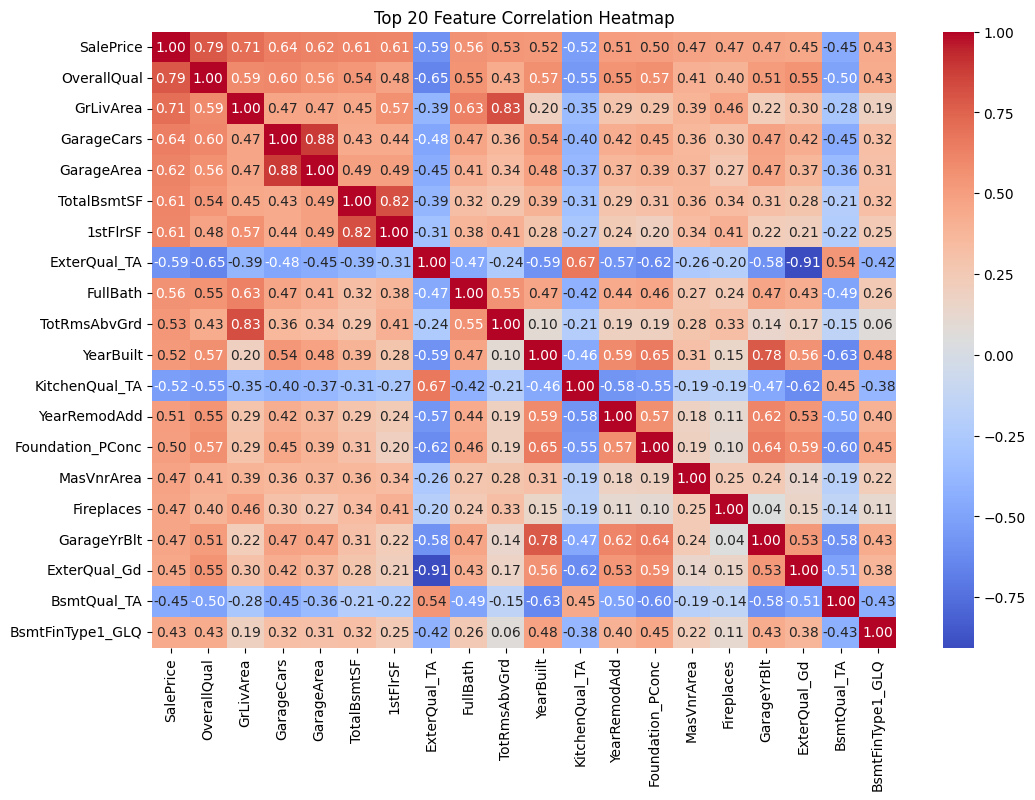

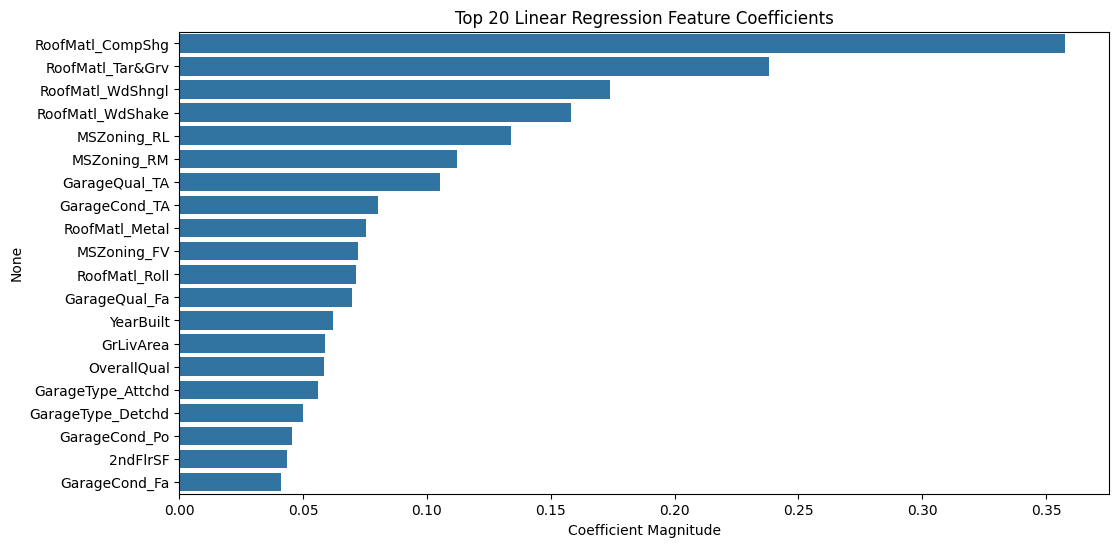

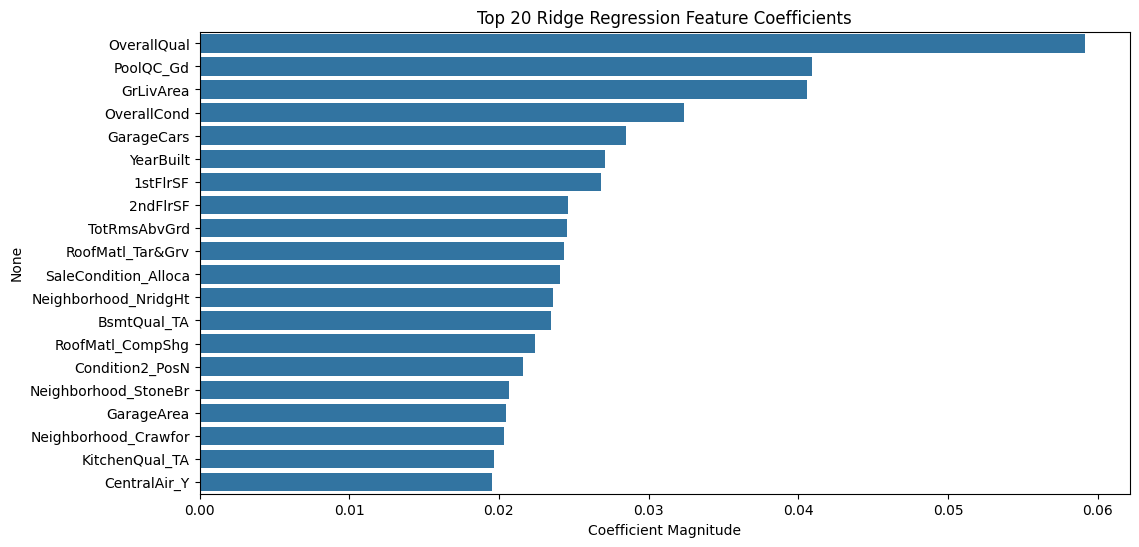

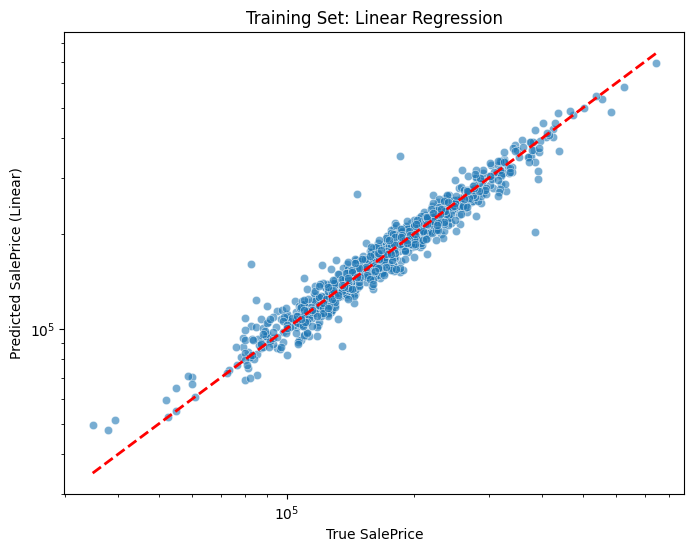

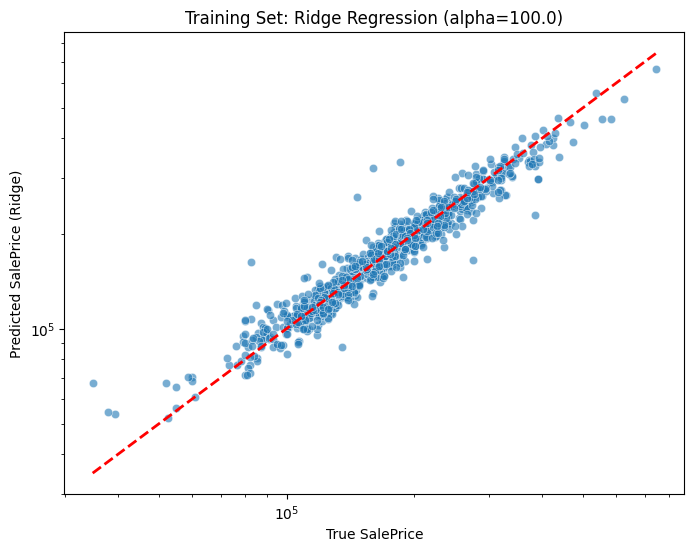

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# =========================
# 0️⃣ Prepare Data
# =========================
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns.drop('SalePrice'), fill_value=0)

# Fill missing numerical values with median
num_cols = df_train_encoded.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('SalePrice')
for col in num_cols:
    median = df_train_encoded[col].median()
    df_train_encoded[col] = df_train_encoded[col].fillna(median)
    df_test_encoded[col] = df_test_encoded[col].fillna(median)

# Features & target
X = df_train_encoded.drop('SalePrice', axis=1)
y = np.log1p(df_train_encoded['SalePrice'])  # log-transform target
X_test = df_test_encoded

# =========================
# 1️⃣ Standardize Features
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Train-validation split for metrics
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# =========================
# 2️⃣ Linear Regression
# =========================
lin_reg = LinearRegression()
# 5-fold CV RMSE
lin_cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lin_rmse_scores = np.sqrt(-lin_cv_scores)
print("Linear Regression CV RMSE:", lin_rmse_scores)
print("Linear Regression CV RMSE mean:", lin_rmse_scores.mean())

# Fit and Validation R2
lin_reg.fit(X_train, y_train)
y_val_pred_lin = lin_reg.predict(X_val)
print("Linear Regression Validation R2:", r2_score(y_val, y_val_pred_lin))

# =========================
# 3️⃣ Ridge Regression
# =========================
alphas = [0.1, 0.3, 1, 3, 10, 30, 100]
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
y_val_pred_ridge = ridge_cv.predict(X_val)

print("Best alpha for Ridge:", ridge_cv.alpha_)

ridge_cv_scores = cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
ridge_rmse_scores = np.sqrt(-ridge_cv_scores)
print("Ridge CV RMSE scores:", ridge_rmse_scores)
print("Ridge CV RMSE mean:", ridge_rmse_scores.mean())
print("Ridge Validation R2:", r2_score(y_val, y_val_pred_ridge))

# Sequential alpha experiments
for alpha in [0.1, 1, 10, 100, 1000]:
    ridge = RidgeCV(alphas=[alpha], scoring='neg_mean_squared_error', cv=5)
    ridge.fit(X_train, y_train)
    y_val_pred_alpha = ridge.predict(X_val)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_val_pred_alpha)))
    print(f"Ridge alpha={alpha}, Validation RMSE: {rmse:.2f}")

# =========================
# 4️⃣ Visualization
# =========================
# Top 20 Feature Correlation Heatmap
corr_matrix = df_train_encoded.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(20).index

plt.figure(figsize=(12,8))
sns.heatmap(df_train_encoded[top_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Top 20 Feature Correlation Heatmap")
plt.show()

# Linear & Ridge top 20 coefficients
lin_coeffs = pd.Series(lin_reg.coef_, index=X.columns)
top_lin_coeffs = lin_coeffs.abs().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_lin_coeffs.values, y=top_lin_coeffs.index)
plt.title("Top 20 Linear Regression Feature Coefficients")
plt.xlabel("Coefficient Magnitude")
plt.show()

ridge_coeffs = pd.Series(ridge_cv.coef_, index=X.columns)
top_ridge_coeffs = ridge_coeffs.abs().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_ridge_coeffs.values, y=top_ridge_coeffs.index)
plt.title("Top 20 Ridge Regression Feature Coefficients")
plt.xlabel("Coefficient Magnitude")
plt.show()

# Scatter plots
y_train_exp = np.expm1(y_train)
y_train_pred_exp_lin = np.expm1(lin_reg.predict(X_train))
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_train_exp, y=y_train_pred_exp_lin, alpha=0.6)
plt.plot([y_train_exp.min(), y_train_exp.max()], [y_train_exp.min(), y_train_exp.max()],
         color='red', linestyle='--', lw=2)
plt.xscale('log'); plt.yscale('log')
plt.xlabel("True SalePrice"); plt.ylabel("Predicted SalePrice (Linear)")
plt.title("Training Set: Linear Regression")
plt.show()

y_train_pred_exp_ridge = np.expm1(ridge_cv.predict(X_train))
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_train_exp, y=y_train_pred_exp_ridge, alpha=0.6)
plt.plot([y_train_exp.min(), y_train_exp.max()], [y_train_exp.min(), y_train_exp.max()],
         color='red', linestyle='--', lw=2)
plt.xscale('log'); plt.yscale('log')
plt.xlabel("True SalePrice"); plt.ylabel("Predicted SalePrice (Ridge)")
plt.title(f"Training Set: Ridge Regression (alpha={ridge_cv.alpha_})")
plt.show()
